In [0]:
!pip install torch torchvision pandas scikit-learn matplotlib tables pyarrow

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

import math
from collections import defaultdict, OrderedDict
import copy

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, mean_absolute_error, matthews_corrcoef

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline


# Build dataset

In [0]:
!curl https://data.ukedc.rl.ac.uk/browse/edc/efficiency/residential/EnergyConsumption/Domestic/UK-DALE-2015/UK-DALE-disaggregated/ukdale.h5.tgz -o ukdale.h5.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2835M  100 2835M    0     0  35.5M      0  0:01:19  0:01:19 --:--:-- 53.9M0:00:02 53.7M


In [0]:
!tar xvfz ukdale.h5.tgz

ukdale.h5


In [0]:
!rm ukdale.h5.tgz

In [0]:
!ls -l

total 3267076
-rw-r--r-- 1 root root     370852 Oct 16 08:04 TPNet_UKDALE_run.ipynb
-rw-r--r-- 1 root root        850 Oct 16 07:52 house_1_labels.dat
-rw-r--r-- 1 root root        228 Oct 16 07:52 house_2_labels.dat
-rw-r--r-- 1 root root         60 Oct 16 07:52 house_3_labels.dat
-rw-r--r-- 1 root root        111 Oct 16 07:52 house_4_labels.dat
-rw-r--r-- 1 root root        376 Oct 16 07:52 house_5_labels.dat
-rw-r--r-- 1 root root          0 Oct 16 07:50 onstart.log
-rw-r--r-- 1 root root         75 Oct 16 07:50 onstart.sh
-rw-rw-r-- 1 1000 1000 3345086829 Jan  5  2015 ukdale.h5


In [0]:
store = pd.HDFStore('ukdale.h5')

In [0]:
def resample_meter(store=None, building=1, meter=1, period='1min', cutoff=1000.):
    key = '/building{}/elec/meter{}'.format(building,meter)
    m = store[key]
    v = m.values.flatten()
    t = m.index
    s = pd.Series(v, index=t).clip(0.,cutoff)
    s[s<10.] = 0.
    return s.resample('1s').ffill(limit=300).fillna(0.).resample(period).mean().tz_convert('UTC')


In [0]:
def get_series(datastore, house, label, cutoff):
    filename = './house_%1d_labels.dat' %house
    print(filename)
    labels = pd.read_csv(filename, delimiter=' ', header=None, index_col=0).to_dict()[1]
    
    for i in labels:
        if labels[i] == label:
            print(i, labels[i])
            s = resample_meter(store, house, i, '1min', cutoff)
            #s = resample_meter(store, house, i, '6s', cutoff)
    
    s.index.name = 'datetime'
    
    return s

In [0]:
house = 1
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washing_machine', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dishwasher', 2500.)
a5.name = 'dish_washer'
ds_1 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_1.fillna(method='pad', inplace=True)

ds_1_train = ds_1[pd.datetime(2013,4,12):pd.datetime(2014,12,15)]
ds_1_valid = ds_1[pd.datetime(2014,12,15):]

./house_1_labels.dat
1 aggregate
./house_1_labels.dat
10 kettle
./house_1_labels.dat
12 fridge
./house_1_labels.dat
5 washing_machine
./house_1_labels.dat
13 microwave
./house_1_labels.dat
6 dishwasher


In [0]:
house = 2
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washing_machine', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dish_washer', 2500.)
a5.name = 'dish_washer'
ds_2 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_2.fillna(method='pad', inplace=True)

ds_2_train = ds_2[pd.datetime(2013,5,22):pd.datetime(2013,10,3,6,16)]
ds_2_valid = ds_2[pd.datetime(2013,10,3,6,16):]

./house_2_labels.dat
1 aggregate
./house_2_labels.dat
8 kettle
./house_2_labels.dat
14 fridge
./house_2_labels.dat
12 washing_machine
./house_2_labels.dat
15 microwave
./house_2_labels.dat
13 dish_washer


In [0]:
house = 3
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = 0.*m
a2.name = 'fridge'
a3 = 0.*m
a3.name = 'washing_machine'
a4 = 0.*m
a4.name = 'microwave'
a5 = 0.*m
a5.name = 'dish_washer'
ds_3 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_3.fillna(method='pad', inplace=True)

ds_3_train = ds_3[pd.datetime(2013,2,27):pd.datetime(2013,4,1,6,15)]
ds_3_valid = ds_3[pd.datetime(2013,4,1,6,15):]

./house_3_labels.dat
1 aggregate
./house_3_labels.dat
2 kettle


In [0]:
house = 4
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle_radio', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'freezer', 300.)
a2.name = 'fridge'
a3 = 0.*m
a3.name = 'washing_machine'
a4 = 0.*m
a4.name = 'microwave'
a5 = 0.*m
a5.name = 'dish_washer'
ds_4 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_4.fillna(method='pad', inplace=True)

ds_4_train = ds_4[pd.datetime(2013,3,9):pd.datetime(2013,9,24,6,15)]
ds_4_valid = ds_4[pd.datetime(2013,9,24,6,15):]

./house_4_labels.dat
1 aggregate
./house_4_labels.dat
3 kettle_radio
./house_4_labels.dat
5 freezer


In [0]:
house = 5
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge_freezer', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washer_dryer', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dishwasher', 2500.)
a5.name = 'dish_washer'
ds_5 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_5.fillna(method='pad', inplace=True)

ds_5_train = ds_5[pd.datetime(2014,6,29):pd.datetime(2014,9,1)]
ds_5_valid = ds_5[pd.datetime(2014,9,1):]

./house_5_labels.dat
1 aggregate
./house_5_labels.dat
18 kettle
./house_5_labels.dat
19 fridge_freezer
./house_5_labels.dat
24 washer_dryer
./house_5_labels.dat
23 microwave
./house_5_labels.dat
22 dishwasher


In [0]:
ds_1_train.reset_index().to_feather('./UKDALE_1_train.feather')
ds_2_train.reset_index().to_feather('./UKDALE_2_train.feather')
ds_3_train.reset_index().to_feather('./UKDALE_3_train.feather')
ds_4_train.reset_index().to_feather('./UKDALE_4_train.feather')
ds_5_train.reset_index().to_feather('./UKDALE_5_train.feather')

ds_1_valid.reset_index().to_feather('./UKDALE_1_valid.feather')
ds_2_valid.reset_index().to_feather('./UKDALE_2_valid.feather')
ds_3_valid.reset_index().to_feather('./UKDALE_3_valid.feather')
ds_4_valid.reset_index().to_feather('./UKDALE_4_valid.feather')
ds_5_valid.reset_index().to_feather('./UKDALE_5_valid.feather')

# Read the feather dataframe resampled


In [0]:
def get_status(app, threshold, min_off, min_on):
    condition = app > threshold
    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    on_events = idx[:,0].copy()
    off_events = idx[:,1].copy()
    assert len(on_events) == len(off_events)

    if len(on_events) > 0:
        off_duration = on_events[1:] - off_events[:-1]
        off_duration = np.insert(off_duration, 0, 1000.)
        on_events = on_events[off_duration > min_off]
        off_events = off_events[np.roll(off_duration, -1) > min_off]
        assert len(on_events) == len(off_events)

        on_duration = off_events - on_events
        on_events = on_events[on_duration > min_on]
        off_events = off_events[on_duration > min_on]

    s = app.copy()
    #s.iloc[:] = 0.
    s[:] = 0.

    for on, off in zip(on_events, off_events):
        #s.iloc[on:off] = 1.
        s[on:off] = 1.
    
    return s

In [0]:
class Power(data.Dataset):
    def __init__(self, meter=None, appliance=None, status=None, 
                 length=256, border=680, max_power=1., train=False):
        self.length = length
        self.border = border
        self.max_power = max_power
        self.train = train

        self.meter = meter.copy()/self.max_power
        self.appliance = appliance.copy()/self.max_power
        self.status = status.copy()

        self.epochs = (len(self.meter) - 2*self.border) // self.length
        
    def __getitem__(self, index):
        i = index * self.length + self.border
        if self.train:
            i = np.random.randint(self.border, len(self.meter) - self.length - self.border)

        x = self.meter.iloc[i-self.border:i+self.length+self.border].values.astype('float32')
        y = self.appliance.iloc[i:i+self.length].values.astype('float32')
        s = self.status.iloc[i:i+self.length].values.astype('float32')
        x -= x.mean()
        
        return x, y, s

    def __len__(self):
        return self.epochs

In [0]:
class Encoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=3, padding=1, stride=1):
        super(Encoder, self).__init__()
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=kernel_size, padding=padding, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        #return self.bn(F.relu(self.conv(x)))
        return self.drop(self.bn(F.relu(self.conv(x))))

class TemporalPooling(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2):
        super(TemporalPooling, self).__init__()
        self.kernel_size = kernel_size
        self.pool = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.kernel_size)
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=1, padding=0)
        #self.upsample = nn.Upsample( scale_factor=kernel_size, mode='linear', align_corners=True)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.bn(F.relu(x))
        #return self.upsample(x)
        #return self.drop(self.upsample(x))
        return self.drop(F.interpolate(x, scale_factor=self.kernel_size, mode='linear', align_corners=True))

class Decoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2, stride=2):
        super(Decoder, self).__init__()
        self.conv = nn.ConvTranspose1d(in_features, out_features, kernel_size=kernel_size, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        return F.relu(self.conv(x))

class PTPNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(PTPNet, self).__init__()
        p = 2
        k = 1
        features = init_features
        self.encoder1 = Encoder(in_channels, features, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder2 = Encoder(features * 1**k, features * 2**k, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder3 = Encoder(features * 2**k, features * 4**k, kernel_size=3, padding=0)
        self.pool3 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder4 = Encoder(features * 4**k, features * 8**k, kernel_size=3, padding=0)
        
        self.tpool1 = TemporalPooling(features*8**k, features*2**k, kernel_size=5)
        self.tpool2 = TemporalPooling(features*8**k, features*2**k, kernel_size=10)
        self.tpool3 = TemporalPooling(features*8**k, features*2**k, kernel_size=20)
        self.tpool4 = TemporalPooling(features*8**k, features*2**k, kernel_size=30)

        self.decoder = Decoder(2*features * 8**k, features * 1**k, kernel_size=p**3, stride=p**3)

        self.activation = nn.Conv1d(features * 1**k, out_channels, kernel_size=1, padding=0)

        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        tp1 = self.tpool1(enc4)
        tp2 = self.tpool2(enc4)
        tp3 = self.tpool3(enc4)
        tp4 = self.tpool4(enc4)

        dec = self.decoder(torch.cat([enc4, tp1, tp2, tp3, tp4], dim=1))

        act = self.activation(dec)
        return act

x = torch.randn(32,1,60*8+2*16)
model = PTPNet(1,3,32)
print(model(x).shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

torch.Size([32, 3, 480])
327619


In [0]:
def train_model(model, batch_size, n_epochs, filename):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the test loss as the model trains
    test_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    # to track the average test loss per epoch as the model trains
    avg_test_losses = [] 
    
    min_loss = np.inf
    
    # initialize the early_stopping object
    #patience = 10
    #early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target_power, target_status) in enumerate(train_loader, 1):
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output_status = model(data).permute(0,2,1)
            # calculate the loss
            loss = criterion(output_status, target_status)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target_power, target_status in valid_loader:
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output_status = model(data).permute(0,2,1)
            # calculate the loss
            loss = criterion(output_status, target_status)
            # record validation loss
            valid_losses.append(loss.item())

        ##################    
        # test the model #
        ##################
        model.eval() # prep model for evaluation
        for data, target_power, target_status in test_loader:
            data = data.unsqueeze(1).cuda()
            target_power = target_power.cuda()
            target_status = target_status.cuda()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output_status = model(data).permute(0,2,1)
            # calculate the loss
            loss = criterion(output_status, target_status)
            # record validation loss
            test_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        test_loss = np.average(test_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_test_losses.append(test_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'test_loss: {test_loss:.5f} ')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        test_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        #early_stopping(valid_loss, model)
        #if (early_stopping.early_stop and (epoch > 80)):
        #    break
        
        if valid_loss < min_loss:
            print(f'Validation loss decreased ({min_loss:.6f} --> {valid_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), filename)
            min_loss = valid_loss
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(filename))
    
    return  model, avg_train_losses, avg_valid_losses, avg_test_losses

In [0]:
def evaluate_activation(model, loader, a):
    x_true = []
    s_true = []
    p_true = []
    s_hat = []
    
    model.eval()
    with torch.no_grad():
        for x, p, s in loader:
            x = x.unsqueeze(1).cuda()
            p = p.permute(0,2,1)[:,a,:]
            s = s.permute(0,2,1)[:,a,:]
            
            sh = model(x)
            sh = torch.sigmoid(sh[:,a,:])
            
            s_hat.append(sh.contiguous().view(-1).detach().cpu().numpy())
            
            x_true.append(x[:,:,BORDER:-BORDER].contiguous().view(-1).detach().cpu().numpy())
            s_true.append(s.contiguous().view(-1).detach().cpu().numpy())
            p_true.append(p.contiguous().view(-1).detach().cpu().numpy())
    x_true = np.hstack(x_true)
    s_true = np.hstack(s_true)
    p_true = np.hstack(p_true)
    s_hat = np.hstack(s_hat)

    return x_true, p_true, s_true, s_hat

In [0]:
APPLIANCE = ['fridge', 'dish_washer', 'washing_machine']
THRESHOLD = [50., 10., 20.]
MIN_ON = [1., 30., 30.]
MIN_OFF = [1., 30., 3.]

METER = 'aggregate'
SEQ_LEN = 60*8
BORDER = 16
BATCH_SIZE = 32

MAX_POWER = 2000.

In [0]:
ds_meter = []
ds_appliance = []
ds_status = []
for i in range(5):
    ds = pd.read_feather('./UKDALE_%d_train.feather' %(i+1))
    ds.set_index('datetime', inplace=True)
    
    meter = ds[METER]
    appliances = ds[APPLIANCE]
    
    status = pd.DataFrame()
    for a in range(len(APPLIANCE)):
        status = pd.concat([status, get_status(ds[APPLIANCE[a]], THRESHOLD[a], MIN_OFF[a], MIN_ON[a])], axis=1)
    
    ds_meter.append(meter)
    ds_appliance.append(appliances)
    ds_status.append(status)

ds_len = [len(ds_meter[i]) for i in range(5)]

In [0]:
(ds_status[1].diff()==1).sum()

fridge             3525
dish_washer          98
washing_machine      54
dtype: int64

In [0]:
ds_status[1].describe()

,fridge,dish_washer,washing_machine
count,193337.00000,193337.000000,193337.000000
mean,0.37792,0.028918,0.011317
std,0.48503,0.167543,0.105773
min,0.00000,0.000000,0.000000
25%,0.00000,0.000000,0.000000
50%,0.00000,0.000000,0.000000
75%,1.00000,0.000000,0.000000
max,1.00000,1.000000,1.000000


In [0]:
ds_house_train = [Power(ds_meter[i][:int(0.8*ds_len[i])], 
                        ds_appliance[i][:int(0.8*ds_len[i])], 
                        ds_status[i][:int(0.8*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, True) for i in range(5+0)]

ds_house_valid = [Power(ds_meter[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        ds_appliance[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])],
                        ds_status[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_test  = [Power(ds_meter[i][int(0.9*ds_len[i]):], 
                        ds_appliance[i][int(0.9*ds_len[i]):],
                        ds_status[i][int(0.9*ds_len[i]):], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_total  = [Power(ds_meter[i], ds_appliance[i], ds_status[i], 
                         SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_train_seen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                ds_house_train[1], 
                                                #ds_house_train[2], 
                                                #ds_house_train[3],
                                                ds_house_train[4]
                                                ])
ds_valid_seen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                                #ds_house_valid[1], 
                                                #ds_house_valid[2], 
                                                #ds_house_valid[3], 
                                                #ds_house_valid[4]
                                                ])

dl_train_seen = DataLoader(dataset = ds_train_seen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_seen = DataLoader(dataset = ds_valid_seen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_seen = DataLoader(dataset = ds_house_test[0], batch_size = BATCH_SIZE, shuffle=False)

ds_train_unseen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                  #ds_house_train[1], 
                                                  #ds_house_train[2], 
                                                  #ds_house_train[3], 
                                                  ds_house_train[4]
                                                  ])
ds_valid_unseen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                                  #ds_house_valid[1], 
                                                  #ds_house_valid[2], 
                                                  #ds_house_valid[3], 
                                                  ds_house_valid[4]
                                                  ])
dl_train_unseen = DataLoader(dataset = ds_train_unseen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_unseen = DataLoader(dataset = ds_valid_unseen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_unseen = DataLoader(dataset = ds_house_total[1], batch_size = BATCH_SIZE, shuffle=False)

dl_house_test = [DataLoader(dataset = ds_house_test[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_valid = [DataLoader(dataset = ds_house_valid[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_total = [DataLoader(dataset = ds_house_total[i], batch_size = 1, shuffle=False) for i in range(5)]

In [0]:
dataiter = iter(dl_house_test[1])

(-0.5, 1.5)

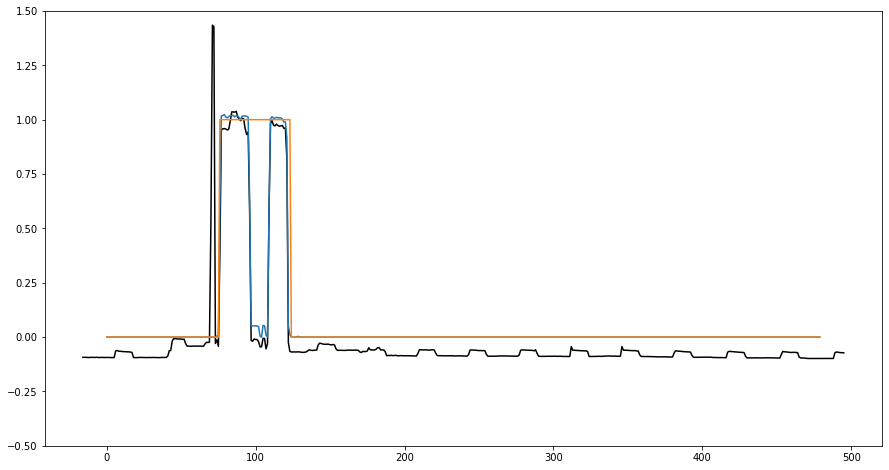

In [0]:
plt.figure(figsize=(15,8))
#x, y, s = dataiter.next()
a = 1
for i in range(100):
    x, y, s = dataiter.next()
    if y[0,:,a].sum() > 0:
        break
    if s[0,:,a].sum() > 0:
        break
plt.plot(np.arange(-BORDER, SEQ_LEN + BORDER), x[0,:].detach().numpy(), 'k-')
plt.plot(y[0,:,a].detach().numpy())
plt.plot(s[0,:,a].detach().numpy())
plt.ylim([-0.5,1.5])

In [0]:
batch_size = BATCH_SIZE
n_epochs = 300

train_loader = dl_train_seen
valid_loader = dl_valid_seen
test_loader = dl_test_seen

#i = 0
for i in range(20):
    print('TRAINING MODEL %d' %i)
    # Instantiate the model
    model = PTPNet(1,3,32).cuda()
    optimizer = optim.Adam(model.parameters(), lr=1.E-4)
    criterion = nn.BCEWithLogitsLoss()
    fn = 'UKDALE_seen_%d.pth' %i
    model, train_loss, valid_loss, test_loss = train_model(model, batch_size, n_epochs, fn)

TRAINING MODEL 0
[  1/300] train_loss: 0.58662 valid_loss: 0.50422 test_loss: 0.50825 
Validation loss decreased (inf --> 0.504216).  Saving model ...
[  2/300] train_loss: 0.41906 valid_loss: 0.38410 test_loss: 0.39097 
Validation loss decreased (0.504216 --> 0.384097).  Saving model ...
[  3/300] train_loss: 0.33519 valid_loss: 0.32905 test_loss: 0.33933 
Validation loss decreased (0.384097 --> 0.329049).  Saving model ...
[  4/300] train_loss: 0.28827 valid_loss: 0.29103 test_loss: 0.30620 
Validation loss decreased (0.329049 --> 0.291033).  Saving model ...
[  5/300] train_loss: 0.25685 valid_loss: 0.25705 test_loss: 0.27648 
Validation loss decreased (0.291033 --> 0.257051).  Saving model ...
[  6/300] train_loss: 0.23341 valid_loss: 0.23138 test_loss: 0.24990 
Validation loss decreased (0.257051 --> 0.231382).  Saving model ...
[  7/300] train_loss: 0.20863 valid_loss: 0.21102 test_loss: 0.22715 
Validation loss decreased (0.231382 --> 0.211021).  Saving model ...
[  8/300] train

[ 75/300] train_loss: 0.09591 valid_loss: 0.10404 test_loss: 0.11781 
Validation loss decreased (0.105442 --> 0.104037).  Saving model ...
[ 76/300] train_loss: 0.09437 valid_loss: 0.10141 test_loss: 0.11759 
Validation loss decreased (0.104037 --> 0.101406).  Saving model ...
[ 77/300] train_loss: 0.09354 valid_loss: 0.10586 test_loss: 0.11602 
[ 78/300] train_loss: 0.09317 valid_loss: 0.10706 test_loss: 0.11748 
[ 79/300] train_loss: 0.09740 valid_loss: 0.10561 test_loss: 0.11741 
[ 80/300] train_loss: 0.09200 valid_loss: 0.10185 test_loss: 0.11456 
[ 81/300] train_loss: 0.09441 valid_loss: 0.10078 test_loss: 0.11485 
Validation loss decreased (0.101406 --> 0.100780).  Saving model ...
[ 82/300] train_loss: 0.09104 valid_loss: 0.10387 test_loss: 0.11503 
[ 83/300] train_loss: 0.09570 valid_loss: 0.10198 test_loss: 0.11408 
[ 84/300] train_loss: 0.09064 valid_loss: 0.10259 test_loss: 0.11530 
[ 85/300] train_loss: 0.09054 valid_loss: 0.09941 test_loss: 0.11243 
Validation loss decreas

[172/300] train_loss: 0.07785 valid_loss: 0.08936 test_loss: 0.09952 
[173/300] train_loss: 0.07778 valid_loss: 0.09107 test_loss: 0.09924 
[174/300] train_loss: 0.07649 valid_loss: 0.08701 test_loss: 0.09899 
[175/300] train_loss: 0.07514 valid_loss: 0.08930 test_loss: 0.09955 
[176/300] train_loss: 0.07641 valid_loss: 0.08782 test_loss: 0.09843 
[177/300] train_loss: 0.07519 valid_loss: 0.08773 test_loss: 0.10112 
[178/300] train_loss: 0.07922 valid_loss: 0.08699 test_loss: 0.09991 
[179/300] train_loss: 0.07938 valid_loss: 0.08535 test_loss: 0.09850 
Validation loss decreased (0.086870 --> 0.085351).  Saving model ...
[180/300] train_loss: 0.07785 valid_loss: 0.08740 test_loss: 0.10034 
[181/300] train_loss: 0.07766 valid_loss: 0.08666 test_loss: 0.09939 
[182/300] train_loss: 0.07640 valid_loss: 0.08459 test_loss: 0.09786 
Validation loss decreased (0.085351 --> 0.084592).  Saving model ...
[183/300] train_loss: 0.07843 valid_loss: 0.08616 test_loss: 0.09783 
[184/300] train_loss: 

[278/300] train_loss: 0.06671 valid_loss: 0.07970 test_loss: 0.09092 
[279/300] train_loss: 0.06871 valid_loss: 0.08050 test_loss: 0.09332 
[280/300] train_loss: 0.06946 valid_loss: 0.09356 test_loss: 0.09295 
[281/300] train_loss: 0.06904 valid_loss: 0.07981 test_loss: 0.09225 
[282/300] train_loss: 0.06703 valid_loss: 0.08041 test_loss: 0.09207 
[283/300] train_loss: 0.06602 valid_loss: 0.08100 test_loss: 0.09199 
[284/300] train_loss: 0.06686 valid_loss: 0.08037 test_loss: 0.09206 
[285/300] train_loss: 0.07231 valid_loss: 0.07975 test_loss: 0.09372 
[286/300] train_loss: 0.06855 valid_loss: 0.07879 test_loss: 0.09109 
Validation loss decreased (0.079157 --> 0.078792).  Saving model ...
[287/300] train_loss: 0.06886 valid_loss: 0.07887 test_loss: 0.09142 
[288/300] train_loss: 0.06695 valid_loss: 0.07975 test_loss: 0.09173 
[289/300] train_loss: 0.06759 valid_loss: 0.07884 test_loss: 0.09149 
[290/300] train_loss: 0.06670 valid_loss: 0.07931 test_loss: 0.09143 
[291/300] train_loss:

[ 55/300] train_loss: 0.10155 valid_loss: 0.10984 test_loss: 0.12669 
[ 56/300] train_loss: 0.10202 valid_loss: 0.10695 test_loss: 0.12287 
Validation loss decreased (0.107379 --> 0.106954).  Saving model ...
[ 57/300] train_loss: 0.09985 valid_loss: 0.10924 test_loss: 0.12341 
[ 58/300] train_loss: 0.10065 valid_loss: 0.10825 test_loss: 0.12217 
[ 59/300] train_loss: 0.10021 valid_loss: 0.10799 test_loss: 0.12313 
[ 60/300] train_loss: 0.10186 valid_loss: 0.10884 test_loss: 0.12303 
[ 61/300] train_loss: 0.10035 valid_loss: 0.10383 test_loss: 0.12029 
Validation loss decreased (0.106954 --> 0.103833).  Saving model ...
[ 62/300] train_loss: 0.10067 valid_loss: 0.10503 test_loss: 0.12032 
[ 63/300] train_loss: 0.09864 valid_loss: 0.10576 test_loss: 0.11933 
[ 64/300] train_loss: 0.09821 valid_loss: 0.10660 test_loss: 0.12037 
[ 65/300] train_loss: 0.09642 valid_loss: 0.10695 test_loss: 0.11950 
[ 66/300] train_loss: 0.09788 valid_loss: 0.10486 test_loss: 0.11930 
[ 67/300] train_loss: 

[149/300] train_loss: 0.07909 valid_loss: 0.09137 test_loss: 0.10167 
[150/300] train_loss: 0.08150 valid_loss: 0.09077 test_loss: 0.10179 
[151/300] train_loss: 0.07912 valid_loss: 0.08812 test_loss: 0.10192 
[152/300] train_loss: 0.08014 valid_loss: 0.08818 test_loss: 0.10227 
[153/300] train_loss: 0.07928 valid_loss: 0.08615 test_loss: 0.10160 
Validation loss decreased (0.086876 --> 0.086154).  Saving model ...
[154/300] train_loss: 0.07949 valid_loss: 0.08721 test_loss: 0.10104 
[155/300] train_loss: 0.07955 valid_loss: 0.08777 test_loss: 0.10130 
[156/300] train_loss: 0.07878 valid_loss: 0.08684 test_loss: 0.10104 
[157/300] train_loss: 0.07834 valid_loss: 0.08792 test_loss: 0.10141 
[158/300] train_loss: 0.08247 valid_loss: 0.08842 test_loss: 0.10078 
[159/300] train_loss: 0.07858 valid_loss: 0.08970 test_loss: 0.10132 
[160/300] train_loss: 0.07730 valid_loss: 0.08677 test_loss: 0.10059 
[161/300] train_loss: 0.07926 valid_loss: 0.08623 test_loss: 0.10026 
[162/300] train_loss:

[252/300] train_loss: 0.07113 valid_loss: 0.08249 test_loss: 0.09543 
[253/300] train_loss: 0.07052 valid_loss: 0.08180 test_loss: 0.09436 
[254/300] train_loss: 0.06916 valid_loss: 0.08218 test_loss: 0.09528 
[255/300] train_loss: 0.07176 valid_loss: 0.08148 test_loss: 0.09449 
[256/300] train_loss: 0.07009 valid_loss: 0.08228 test_loss: 0.09475 
[257/300] train_loss: 0.06948 valid_loss: 0.08119 test_loss: 0.09362 
[258/300] train_loss: 0.07137 valid_loss: 0.08097 test_loss: 0.09340 
[259/300] train_loss: 0.07113 valid_loss: 0.08094 test_loss: 0.09377 
[260/300] train_loss: 0.06870 valid_loss: 0.08074 test_loss: 0.09368 
[261/300] train_loss: 0.06937 valid_loss: 0.08048 test_loss: 0.09318 
[262/300] train_loss: 0.07072 valid_loss: 0.08116 test_loss: 0.09306 
[263/300] train_loss: 0.07059 valid_loss: 0.08229 test_loss: 0.09467 
[264/300] train_loss: 0.06969 valid_loss: 0.08100 test_loss: 0.09374 
[265/300] train_loss: 0.07057 valid_loss: 0.08184 test_loss: 0.09460 
[266/300] train_loss

[ 35/300] train_loss: 0.11448 valid_loss: 0.12756 test_loss: 0.14229 
[ 36/300] train_loss: 0.11598 valid_loss: 0.11913 test_loss: 0.13622 
Validation loss decreased (0.122927 --> 0.119133).  Saving model ...
[ 37/300] train_loss: 0.11535 valid_loss: 0.11993 test_loss: 0.13562 
[ 38/300] train_loss: 0.11062 valid_loss: 0.11966 test_loss: 0.13573 
[ 39/300] train_loss: 0.11193 valid_loss: 0.12180 test_loss: 0.13483 
[ 40/300] train_loss: 0.11187 valid_loss: 0.12047 test_loss: 0.13680 
[ 41/300] train_loss: 0.11009 valid_loss: 0.11881 test_loss: 0.13437 
Validation loss decreased (0.119133 --> 0.118806).  Saving model ...
[ 42/300] train_loss: 0.11078 valid_loss: 0.11548 test_loss: 0.13188 
Validation loss decreased (0.118806 --> 0.115477).  Saving model ...
[ 43/300] train_loss: 0.10954 valid_loss: 0.12001 test_loss: 0.13297 
[ 44/300] train_loss: 0.11147 valid_loss: 0.11738 test_loss: 0.13086 
[ 45/300] train_loss: 0.11071 valid_loss: 0.11880 test_loss: 0.13232 
[ 46/300] train_loss: 0

[129/300] train_loss: 0.08384 valid_loss: 0.09269 test_loss: 0.10451 
[130/300] train_loss: 0.08296 valid_loss: 0.09328 test_loss: 0.10587 
[131/300] train_loss: 0.08425 valid_loss: 0.09249 test_loss: 0.10457 
[132/300] train_loss: 0.08314 valid_loss: 0.09528 test_loss: 0.10426 
[133/300] train_loss: 0.08182 valid_loss: 0.10176 test_loss: 0.10371 
[134/300] train_loss: 0.08521 valid_loss: 0.09029 test_loss: 0.10309 
Validation loss decreased (0.092392 --> 0.090287).  Saving model ...
[135/300] train_loss: 0.08445 valid_loss: 0.09271 test_loss: 0.10396 
[136/300] train_loss: 0.08311 valid_loss: 0.09081 test_loss: 0.10347 
[137/300] train_loss: 0.08308 valid_loss: 0.09402 test_loss: 0.10275 
[138/300] train_loss: 0.08305 valid_loss: 0.09372 test_loss: 0.10440 
[139/300] train_loss: 0.08389 valid_loss: 0.09367 test_loss: 0.10313 
[140/300] train_loss: 0.08378 valid_loss: 0.09879 test_loss: 0.10234 
[141/300] train_loss: 0.08057 valid_loss: 0.09952 test_loss: 0.10288 
[142/300] train_loss:

[234/300] train_loss: 0.07452 valid_loss: 0.08903 test_loss: 0.09460 
[235/300] train_loss: 0.07428 valid_loss: 0.08348 test_loss: 0.09664 
[236/300] train_loss: 0.07071 valid_loss: 0.08466 test_loss: 0.09534 
[237/300] train_loss: 0.07182 valid_loss: 0.08343 test_loss: 0.09473 
[238/300] train_loss: 0.07342 valid_loss: 0.08242 test_loss: 0.09408 
Validation loss decreased (0.082865 --> 0.082424).  Saving model ...
[239/300] train_loss: 0.07088 valid_loss: 0.08548 test_loss: 0.09517 
[240/300] train_loss: 0.07249 valid_loss: 0.08259 test_loss: 0.09335 
[241/300] train_loss: 0.07137 valid_loss: 0.08451 test_loss: 0.09605 
[242/300] train_loss: 0.07312 valid_loss: 0.08177 test_loss: 0.09472 
Validation loss decreased (0.082424 --> 0.081771).  Saving model ...
[243/300] train_loss: 0.07083 valid_loss: 0.08468 test_loss: 0.09514 
[244/300] train_loss: 0.07208 valid_loss: 0.08276 test_loss: 0.09447 
[245/300] train_loss: 0.07174 valid_loss: 0.08383 test_loss: 0.09374 
[246/300] train_loss: 

[ 25/300] train_loss: 0.12671 valid_loss: 0.13295 test_loss: 0.14597 
Validation loss decreased (0.134823 --> 0.132950).  Saving model ...
[ 26/300] train_loss: 0.12461 valid_loss: 0.12987 test_loss: 0.14600 
Validation loss decreased (0.132950 --> 0.129867).  Saving model ...
[ 27/300] train_loss: 0.12574 valid_loss: 0.12801 test_loss: 0.14449 
Validation loss decreased (0.129867 --> 0.128014).  Saving model ...
[ 28/300] train_loss: 0.12462 valid_loss: 0.12898 test_loss: 0.14476 
[ 29/300] train_loss: 0.12149 valid_loss: 0.12964 test_loss: 0.14327 
[ 30/300] train_loss: 0.11897 valid_loss: 0.12407 test_loss: 0.14034 
Validation loss decreased (0.128014 --> 0.124066).  Saving model ...
[ 31/300] train_loss: 0.11656 valid_loss: 0.12435 test_loss: 0.14126 
[ 32/300] train_loss: 0.11856 valid_loss: 0.12072 test_loss: 0.14104 
Validation loss decreased (0.124066 --> 0.120721).  Saving model ...
[ 33/300] train_loss: 0.11489 valid_loss: 0.12294 test_loss: 0.14037 
[ 34/300] train_loss: 0.1

[140/300] train_loss: 0.08284 valid_loss: 0.09010 test_loss: 0.10467 
Validation loss decreased (0.091443 --> 0.090105).  Saving model ...
[141/300] train_loss: 0.08004 valid_loss: 0.09062 test_loss: 0.10362 
[142/300] train_loss: 0.08285 valid_loss: 0.09855 test_loss: 0.10466 
[143/300] train_loss: 0.08247 valid_loss: 0.09058 test_loss: 0.10355 
[144/300] train_loss: 0.08044 valid_loss: 0.09168 test_loss: 0.10463 
[145/300] train_loss: 0.08116 valid_loss: 0.08942 test_loss: 0.10428 
Validation loss decreased (0.090105 --> 0.089418).  Saving model ...
[146/300] train_loss: 0.08216 valid_loss: 0.09052 test_loss: 0.10331 
[147/300] train_loss: 0.08156 valid_loss: 0.09127 test_loss: 0.10414 
[148/300] train_loss: 0.08358 valid_loss: 0.08946 test_loss: 0.10317 
[149/300] train_loss: 0.08142 valid_loss: 0.08991 test_loss: 0.10324 
[150/300] train_loss: 0.08120 valid_loss: 0.09202 test_loss: 0.10354 
[151/300] train_loss: 0.07991 valid_loss: 0.09563 test_loss: 0.10402 
[152/300] train_loss: 

[247/300] train_loss: 0.07276 valid_loss: 0.08570 test_loss: 0.09453 
[248/300] train_loss: 0.06980 valid_loss: 0.08976 test_loss: 0.09490 
[249/300] train_loss: 0.07201 valid_loss: 0.08874 test_loss: 0.09524 
[250/300] train_loss: 0.06974 valid_loss: 0.08662 test_loss: 0.09576 
[251/300] train_loss: 0.07275 valid_loss: 0.09515 test_loss: 0.09548 
[252/300] train_loss: 0.07222 valid_loss: 0.08674 test_loss: 0.09538 
[253/300] train_loss: 0.07068 valid_loss: 0.08997 test_loss: 0.09531 
[254/300] train_loss: 0.07255 valid_loss: 0.08671 test_loss: 0.09523 
[255/300] train_loss: 0.07279 valid_loss: 0.09134 test_loss: 0.09602 
[256/300] train_loss: 0.07174 valid_loss: 0.08273 test_loss: 0.09575 
[257/300] train_loss: 0.07489 valid_loss: 0.08346 test_loss: 0.09450 
[258/300] train_loss: 0.07077 valid_loss: 0.08565 test_loss: 0.09444 
[259/300] train_loss: 0.07170 valid_loss: 0.08256 test_loss: 0.09465 
Validation loss decreased (0.082714 --> 0.082556).  Saving model ...
[260/300] train_loss:

[ 33/300] train_loss: 0.11604 valid_loss: 0.12290 test_loss: 0.13932 
Validation loss decreased (0.125050 --> 0.122896).  Saving model ...
[ 34/300] train_loss: 0.11517 valid_loss: 0.12103 test_loss: 0.13772 
Validation loss decreased (0.122896 --> 0.121027).  Saving model ...
[ 35/300] train_loss: 0.11379 valid_loss: 0.12296 test_loss: 0.13598 
[ 36/300] train_loss: 0.11471 valid_loss: 0.12042 test_loss: 0.13584 
Validation loss decreased (0.121027 --> 0.120423).  Saving model ...
[ 37/300] train_loss: 0.11420 valid_loss: 0.12156 test_loss: 0.13709 
[ 38/300] train_loss: 0.11300 valid_loss: 0.12046 test_loss: 0.13416 
[ 39/300] train_loss: 0.11035 valid_loss: 0.11968 test_loss: 0.13436 
Validation loss decreased (0.120423 --> 0.119681).  Saving model ...
[ 40/300] train_loss: 0.11077 valid_loss: 0.12012 test_loss: 0.13186 
[ 41/300] train_loss: 0.10857 valid_loss: 0.11798 test_loss: 0.13372 
Validation loss decreased (0.119681 --> 0.117975).  Saving model ...
[ 42/300] train_loss: 0.1

[122/300] train_loss: 0.08593 valid_loss: 0.10214 test_loss: 0.10600 
[123/300] train_loss: 0.08674 valid_loss: 0.09851 test_loss: 0.10447 
[124/300] train_loss: 0.08651 valid_loss: 0.09245 test_loss: 0.10604 
[125/300] train_loss: 0.08349 valid_loss: 0.09350 test_loss: 0.10626 
[126/300] train_loss: 0.08397 valid_loss: 0.09064 test_loss: 0.10529 
Validation loss decreased (0.091803 --> 0.090640).  Saving model ...
[127/300] train_loss: 0.08384 valid_loss: 0.09265 test_loss: 0.10549 
[128/300] train_loss: 0.08327 valid_loss: 0.09394 test_loss: 0.10447 
[129/300] train_loss: 0.08450 valid_loss: 0.09630 test_loss: 0.10361 
[130/300] train_loss: 0.08116 valid_loss: 0.09909 test_loss: 0.10486 
[131/300] train_loss: 0.08320 valid_loss: 0.09893 test_loss: 0.10436 
[132/300] train_loss: 0.08334 valid_loss: 0.08972 test_loss: 0.10320 
Validation loss decreased (0.090640 --> 0.089723).  Saving model ...
[133/300] train_loss: 0.08575 valid_loss: 0.09984 test_loss: 0.10524 
[134/300] train_loss: 

[227/300] train_loss: 0.07409 valid_loss: 0.08777 test_loss: 0.09616 
[228/300] train_loss: 0.07238 valid_loss: 0.08605 test_loss: 0.09601 
[229/300] train_loss: 0.07582 valid_loss: 0.09401 test_loss: 0.09627 
[230/300] train_loss: 0.07067 valid_loss: 0.08926 test_loss: 0.09710 
[231/300] train_loss: 0.07435 valid_loss: 0.09362 test_loss: 0.09553 
[232/300] train_loss: 0.07419 valid_loss: 0.08891 test_loss: 0.09517 
[233/300] train_loss: 0.07535 valid_loss: 0.08458 test_loss: 0.09533 
[234/300] train_loss: 0.07186 valid_loss: 0.08349 test_loss: 0.09647 
[235/300] train_loss: 0.07262 valid_loss: 0.09710 test_loss: 0.09592 
[236/300] train_loss: 0.07382 valid_loss: 0.08754 test_loss: 0.09658 
[237/300] train_loss: 0.07253 valid_loss: 0.10080 test_loss: 0.09536 
[238/300] train_loss: 0.07393 valid_loss: 0.08363 test_loss: 0.09542 
[239/300] train_loss: 0.07147 valid_loss: 0.08621 test_loss: 0.09770 
[240/300] train_loss: 0.07074 valid_loss: 0.08305 test_loss: 0.09597 
[241/300] train_loss

[ 21/300] train_loss: 0.12809 valid_loss: 0.13452 test_loss: 0.14996 
Validation loss decreased (0.136170 --> 0.134519).  Saving model ...
[ 22/300] train_loss: 0.12995 valid_loss: 0.13368 test_loss: 0.14828 
Validation loss decreased (0.134519 --> 0.133676).  Saving model ...
[ 23/300] train_loss: 0.12458 valid_loss: 0.13121 test_loss: 0.14555 
Validation loss decreased (0.133676 --> 0.131206).  Saving model ...
[ 24/300] train_loss: 0.12668 valid_loss: 0.13090 test_loss: 0.14437 
Validation loss decreased (0.131206 --> 0.130902).  Saving model ...
[ 25/300] train_loss: 0.12277 valid_loss: 0.12691 test_loss: 0.14179 
Validation loss decreased (0.130902 --> 0.126906).  Saving model ...
[ 26/300] train_loss: 0.11948 valid_loss: 0.12589 test_loss: 0.14123 
Validation loss decreased (0.126906 --> 0.125894).  Saving model ...
[ 27/300] train_loss: 0.11929 valid_loss: 0.12519 test_loss: 0.13964 
Validation loss decreased (0.125894 --> 0.125194).  Saving model ...
[ 28/300] train_loss: 0.119

[110/300] train_loss: 0.08577 valid_loss: 0.11367 test_loss: 0.10728 
[111/300] train_loss: 0.08388 valid_loss: 0.10043 test_loss: 0.10837 
[112/300] train_loss: 0.08679 valid_loss: 0.10096 test_loss: 0.10652 
[113/300] train_loss: 0.08687 valid_loss: 0.10548 test_loss: 0.10543 
[114/300] train_loss: 0.08390 valid_loss: 0.10115 test_loss: 0.10540 
[115/300] train_loss: 0.08455 valid_loss: 0.09742 test_loss: 0.10564 
[116/300] train_loss: 0.08559 valid_loss: 0.09835 test_loss: 0.10510 
[117/300] train_loss: 0.08252 valid_loss: 0.09516 test_loss: 0.10499 
[118/300] train_loss: 0.08592 valid_loss: 0.09536 test_loss: 0.10659 
[119/300] train_loss: 0.08319 valid_loss: 0.09346 test_loss: 0.10479 
[120/300] train_loss: 0.08456 valid_loss: 0.10098 test_loss: 0.10583 
[121/300] train_loss: 0.08361 valid_loss: 0.09503 test_loss: 0.10517 
[122/300] train_loss: 0.08351 valid_loss: 0.11544 test_loss: 0.10402 
[123/300] train_loss: 0.08512 valid_loss: 0.09977 test_loss: 0.10529 
[124/300] train_loss

[215/300] train_loss: 0.07526 valid_loss: 0.09057 test_loss: 0.09434 
[216/300] train_loss: 0.07578 valid_loss: 0.08435 test_loss: 0.09506 
[217/300] train_loss: 0.07224 valid_loss: 0.09184 test_loss: 0.09534 
[218/300] train_loss: 0.07522 valid_loss: 0.08578 test_loss: 0.09447 
[219/300] train_loss: 0.07265 valid_loss: 0.09460 test_loss: 0.09552 
[220/300] train_loss: 0.07195 valid_loss: 0.08475 test_loss: 0.09624 
[221/300] train_loss: 0.07322 valid_loss: 0.08479 test_loss: 0.09498 
[222/300] train_loss: 0.07336 valid_loss: 0.09349 test_loss: 0.09607 
[223/300] train_loss: 0.07451 valid_loss: 0.08707 test_loss: 0.09537 
[224/300] train_loss: 0.07141 valid_loss: 0.09025 test_loss: 0.09513 
[225/300] train_loss: 0.07360 valid_loss: 0.09344 test_loss: 0.09523 
[226/300] train_loss: 0.07174 valid_loss: 0.08626 test_loss: 0.09391 
[227/300] train_loss: 0.07423 valid_loss: 0.10301 test_loss: 0.09648 
[228/300] train_loss: 0.07108 valid_loss: 0.10178 test_loss: 0.09423 
[229/300] train_loss

[ 15/300] train_loss: 0.14421 valid_loss: 0.15346 test_loss: 0.16372 
Validation loss decreased (0.157814 --> 0.153456).  Saving model ...
[ 16/300] train_loss: 0.14564 valid_loss: 0.14858 test_loss: 0.16125 
Validation loss decreased (0.153456 --> 0.148583).  Saving model ...
[ 17/300] train_loss: 0.13885 valid_loss: 0.14811 test_loss: 0.15996 
Validation loss decreased (0.148583 --> 0.148109).  Saving model ...
[ 18/300] train_loss: 0.13697 valid_loss: 0.14714 test_loss: 0.15859 
Validation loss decreased (0.148109 --> 0.147142).  Saving model ...
[ 19/300] train_loss: 0.13693 valid_loss: 0.14388 test_loss: 0.15553 
Validation loss decreased (0.147142 --> 0.143878).  Saving model ...
[ 20/300] train_loss: 0.13045 valid_loss: 0.14093 test_loss: 0.15213 
Validation loss decreased (0.143878 --> 0.140933).  Saving model ...
[ 21/300] train_loss: 0.12935 valid_loss: 0.13878 test_loss: 0.15098 
Validation loss decreased (0.140933 --> 0.138784).  Saving model ...
[ 22/300] train_loss: 0.126

[ 99/300] train_loss: 0.08747 valid_loss: 0.10343 test_loss: 0.10926 
[100/300] train_loss: 0.08748 valid_loss: 0.09473 test_loss: 0.10905 
Validation loss decreased (0.095126 --> 0.094732).  Saving model ...
[101/300] train_loss: 0.08817 valid_loss: 0.09484 test_loss: 0.11022 
[102/300] train_loss: 0.08769 valid_loss: 0.09825 test_loss: 0.10822 
[103/300] train_loss: 0.08602 valid_loss: 0.09922 test_loss: 0.10929 
[104/300] train_loss: 0.08390 valid_loss: 0.09928 test_loss: 0.10926 
[105/300] train_loss: 0.08454 valid_loss: 0.09612 test_loss: 0.10965 
[106/300] train_loss: 0.08415 valid_loss: 0.09415 test_loss: 0.10889 
Validation loss decreased (0.094732 --> 0.094154).  Saving model ...
[107/300] train_loss: 0.08824 valid_loss: 0.10183 test_loss: 0.10869 
[108/300] train_loss: 0.08506 valid_loss: 0.09812 test_loss: 0.10780 
[109/300] train_loss: 0.08446 valid_loss: 0.09331 test_loss: 0.10834 
Validation loss decreased (0.094154 --> 0.093311).  Saving model ...
[110/300] train_loss: 0

[203/300] train_loss: 0.07314 valid_loss: 0.09099 test_loss: 0.09673 
[204/300] train_loss: 0.07475 valid_loss: 0.08670 test_loss: 0.09626 
[205/300] train_loss: 0.07375 valid_loss: 0.09827 test_loss: 0.09704 
[206/300] train_loss: 0.07322 valid_loss: 0.09398 test_loss: 0.09689 
[207/300] train_loss: 0.07609 valid_loss: 0.08947 test_loss: 0.09614 
[208/300] train_loss: 0.07374 valid_loss: 0.08608 test_loss: 0.09698 
[209/300] train_loss: 0.07339 valid_loss: 0.08787 test_loss: 0.09742 
[210/300] train_loss: 0.07308 valid_loss: 0.08894 test_loss: 0.09701 
[211/300] train_loss: 0.07422 valid_loss: 0.09143 test_loss: 0.09588 
[212/300] train_loss: 0.07188 valid_loss: 0.08641 test_loss: 0.09610 
[213/300] train_loss: 0.07475 valid_loss: 0.08695 test_loss: 0.09670 
[214/300] train_loss: 0.07250 valid_loss: 0.08563 test_loss: 0.09651 
[215/300] train_loss: 0.07168 valid_loss: 0.08721 test_loss: 0.09867 
[216/300] train_loss: 0.07369 valid_loss: 0.08637 test_loss: 0.09645 
[217/300] train_loss

[  8/300] train_loss: 0.20417 valid_loss: 0.20190 test_loss: 0.21748 
Validation loss decreased (0.222054 --> 0.201897).  Saving model ...
[  9/300] train_loss: 0.18815 valid_loss: 0.19119 test_loss: 0.20421 
Validation loss decreased (0.201897 --> 0.191189).  Saving model ...
[ 10/300] train_loss: 0.18135 valid_loss: 0.17911 test_loss: 0.19449 
Validation loss decreased (0.191189 --> 0.179106).  Saving model ...
[ 11/300] train_loss: 0.16827 valid_loss: 0.17441 test_loss: 0.18685 
Validation loss decreased (0.179106 --> 0.174407).  Saving model ...
[ 12/300] train_loss: 0.16311 valid_loss: 0.16568 test_loss: 0.18012 
Validation loss decreased (0.174407 --> 0.165679).  Saving model ...
[ 13/300] train_loss: 0.15615 valid_loss: 0.16102 test_loss: 0.17550 
Validation loss decreased (0.165679 --> 0.161021).  Saving model ...
[ 14/300] train_loss: 0.15269 valid_loss: 0.15552 test_loss: 0.17179 
Validation loss decreased (0.161021 --> 0.155523).  Saving model ...
[ 15/300] train_loss: 0.146

[ 89/300] train_loss: 0.09113 valid_loss: 0.10803 test_loss: 0.11364 
[ 90/300] train_loss: 0.09067 valid_loss: 0.10151 test_loss: 0.11315 
[ 91/300] train_loss: 0.09249 valid_loss: 0.10365 test_loss: 0.11620 
[ 92/300] train_loss: 0.09039 valid_loss: 0.10114 test_loss: 0.11435 
[ 93/300] train_loss: 0.08777 valid_loss: 0.09908 test_loss: 0.11196 
[ 94/300] train_loss: 0.08775 valid_loss: 0.10377 test_loss: 0.11154 
[ 95/300] train_loss: 0.08849 valid_loss: 0.10028 test_loss: 0.11290 
[ 96/300] train_loss: 0.09195 valid_loss: 0.09767 test_loss: 0.11090 
Validation loss decreased (0.098338 --> 0.097668).  Saving model ...
[ 97/300] train_loss: 0.08978 valid_loss: 0.09807 test_loss: 0.11255 
[ 98/300] train_loss: 0.08914 valid_loss: 0.10334 test_loss: 0.11312 
[ 99/300] train_loss: 0.08916 valid_loss: 0.09718 test_loss: 0.11132 
Validation loss decreased (0.097668 --> 0.097176).  Saving model ...
[100/300] train_loss: 0.08786 valid_loss: 0.09782 test_loss: 0.11095 
[101/300] train_loss: 

[197/300] train_loss: 0.07505 valid_loss: 0.08643 test_loss: 0.09901 
Validation loss decreased (0.086636 --> 0.086432).  Saving model ...
[198/300] train_loss: 0.07494 valid_loss: 0.08871 test_loss: 0.09866 
[199/300] train_loss: 0.07634 valid_loss: 0.08806 test_loss: 0.09841 
[200/300] train_loss: 0.07394 valid_loss: 0.08820 test_loss: 0.09928 
[201/300] train_loss: 0.07493 valid_loss: 0.08735 test_loss: 0.09940 
[202/300] train_loss: 0.07416 valid_loss: 0.08849 test_loss: 0.09916 
[203/300] train_loss: 0.07380 valid_loss: 0.08524 test_loss: 0.09768 
Validation loss decreased (0.086432 --> 0.085244).  Saving model ...
[204/300] train_loss: 0.07413 valid_loss: 0.08568 test_loss: 0.09853 
[205/300] train_loss: 0.07340 valid_loss: 0.08731 test_loss: 0.09958 
[206/300] train_loss: 0.07535 valid_loss: 0.08722 test_loss: 0.09864 
[207/300] train_loss: 0.07311 valid_loss: 0.08553 test_loss: 0.09715 
[208/300] train_loss: 0.07473 valid_loss: 0.08738 test_loss: 0.09832 
[209/300] train_loss: 

[  3/300] train_loss: 0.34496 valid_loss: 0.34029 test_loss: 0.34093 
Validation loss decreased (0.394811 --> 0.340286).  Saving model ...
[  4/300] train_loss: 0.29611 valid_loss: 0.29544 test_loss: 0.30213 
Validation loss decreased (0.340286 --> 0.295439).  Saving model ...
[  5/300] train_loss: 0.25782 valid_loss: 0.26224 test_loss: 0.27233 
Validation loss decreased (0.295439 --> 0.262240).  Saving model ...
[  6/300] train_loss: 0.23070 valid_loss: 0.23654 test_loss: 0.24997 
Validation loss decreased (0.262240 --> 0.236541).  Saving model ...
[  7/300] train_loss: 0.21229 valid_loss: 0.21437 test_loss: 0.22889 
Validation loss decreased (0.236541 --> 0.214370).  Saving model ...
[  8/300] train_loss: 0.19363 valid_loss: 0.20020 test_loss: 0.21563 
Validation loss decreased (0.214370 --> 0.200196).  Saving model ...
[  9/300] train_loss: 0.18298 valid_loss: 0.18697 test_loss: 0.20226 
Validation loss decreased (0.200196 --> 0.186973).  Saving model ...
[ 10/300] train_loss: 0.171

[ 77/300] train_loss: 0.09700 valid_loss: 0.09972 test_loss: 0.11409 
Validation loss decreased (0.101956 --> 0.099722).  Saving model ...
[ 78/300] train_loss: 0.09299 valid_loss: 0.10122 test_loss: 0.11433 
[ 79/300] train_loss: 0.09506 valid_loss: 0.10127 test_loss: 0.11467 
[ 80/300] train_loss: 0.09682 valid_loss: 0.10101 test_loss: 0.11360 
[ 81/300] train_loss: 0.09040 valid_loss: 0.10291 test_loss: 0.11401 
[ 82/300] train_loss: 0.09345 valid_loss: 0.10364 test_loss: 0.11434 
[ 83/300] train_loss: 0.09153 valid_loss: 0.10115 test_loss: 0.11368 
[ 84/300] train_loss: 0.09392 valid_loss: 0.10415 test_loss: 0.11438 
[ 85/300] train_loss: 0.09413 valid_loss: 0.10236 test_loss: 0.11547 
[ 86/300] train_loss: 0.09265 valid_loss: 0.10005 test_loss: 0.11236 
[ 87/300] train_loss: 0.09021 valid_loss: 0.09895 test_loss: 0.11237 
Validation loss decreased (0.099722 --> 0.098951).  Saving model ...
[ 88/300] train_loss: 0.09056 valid_loss: 0.09776 test_loss: 0.11219 
Validation loss decrea

[176/300] train_loss: 0.07963 valid_loss: 0.08693 test_loss: 0.09998 
[177/300] train_loss: 0.07828 valid_loss: 0.08792 test_loss: 0.09995 
[178/300] train_loss: 0.07675 valid_loss: 0.08729 test_loss: 0.09979 
[179/300] train_loss: 0.08004 valid_loss: 0.08637 test_loss: 0.09843 
Validation loss decreased (0.086458 --> 0.086370).  Saving model ...
[180/300] train_loss: 0.07784 valid_loss: 0.08856 test_loss: 0.10058 
[181/300] train_loss: 0.07895 valid_loss: 0.08700 test_loss: 0.09955 
[182/300] train_loss: 0.07700 valid_loss: 0.08843 test_loss: 0.09919 
[183/300] train_loss: 0.07797 valid_loss: 0.08680 test_loss: 0.09893 
[184/300] train_loss: 0.07486 valid_loss: 0.08687 test_loss: 0.09878 
[185/300] train_loss: 0.07595 valid_loss: 0.08747 test_loss: 0.09859 
[186/300] train_loss: 0.07726 valid_loss: 0.09596 test_loss: 0.09947 
[187/300] train_loss: 0.07756 valid_loss: 0.08696 test_loss: 0.09833 
[188/300] train_loss: 0.07694 valid_loss: 0.08602 test_loss: 0.09833 
Validation loss decre

[279/300] train_loss: 0.06944 valid_loss: 0.08321 test_loss: 0.09658 
[280/300] train_loss: 0.06909 valid_loss: 0.08060 test_loss: 0.09383 
[281/300] train_loss: 0.06914 valid_loss: 0.08030 test_loss: 0.09392 
Validation loss decreased (0.080551 --> 0.080298).  Saving model ...
[282/300] train_loss: 0.07138 valid_loss: 0.08097 test_loss: 0.09370 
[283/300] train_loss: 0.06723 valid_loss: 0.07984 test_loss: 0.09274 
Validation loss decreased (0.080298 --> 0.079839).  Saving model ...
[284/300] train_loss: 0.06801 valid_loss: 0.08106 test_loss: 0.09395 
[285/300] train_loss: 0.06866 valid_loss: 0.07917 test_loss: 0.09328 
Validation loss decreased (0.079839 --> 0.079172).  Saving model ...
[286/300] train_loss: 0.06634 valid_loss: 0.07954 test_loss: 0.09329 
[287/300] train_loss: 0.06890 valid_loss: 0.08136 test_loss: 0.09304 
[288/300] train_loss: 0.06868 valid_loss: 0.08283 test_loss: 0.09417 
[289/300] train_loss: 0.06879 valid_loss: 0.07938 test_loss: 0.09208 
[290/300] train_loss: 0

[ 54/300] train_loss: 0.10249 valid_loss: 0.11359 test_loss: 0.12433 
[ 55/300] train_loss: 0.10111 valid_loss: 0.11344 test_loss: 0.12586 
[ 93/300] train_loss: 0.08912 valid_loss: 0.10271 test_loss: 0.11103 
[ 94/300] train_loss: 0.08978 valid_loss: 0.09842 test_loss: 0.11008 
Validation loss decreased (0.100089 --> 0.098425).  Saving model ...
[ 95/300] train_loss: 0.08714 valid_loss: 0.09914 test_loss: 0.11116 
[ 96/300] train_loss: 0.09106 valid_loss: 0.10218 test_loss: 0.11074 
[ 97/300] train_loss: 0.09001 valid_loss: 0.09832 test_loss: 0.11155 
Validation loss decreased (0.098425 --> 0.098317).  Saving model ...
[ 98/300] train_loss: 0.08846 valid_loss: 0.09871 test_loss: 0.11064 
[ 99/300] train_loss: 0.08932 valid_loss: 0.10036 test_loss: 0.11002 
[100/300] train_loss: 0.08934 valid_loss: 0.09960 test_loss: 0.11132 
[101/300] train_loss: 0.08762 valid_loss: 0.10105 test_loss: 0.11073 
[102/300] train_loss: 0.08539 valid_loss: 0.10024 test_loss: 0.10958 
[103/300] train_loss: 

[193/300] train_loss: 0.07805 valid_loss: 0.08978 test_loss: 0.09876 
[194/300] train_loss: 0.07504 valid_loss: 0.09001 test_loss: 0.09916 
[195/300] train_loss: 0.07408 valid_loss: 0.08885 test_loss: 0.09873 
[196/300] train_loss: 0.07624 valid_loss: 0.08900 test_loss: 0.09881 
[197/300] train_loss: 0.07463 valid_loss: 0.08650 test_loss: 0.09860 
Validation loss decreased (0.086916 --> 0.086500).  Saving model ...
[198/300] train_loss: 0.07578 valid_loss: 0.08851 test_loss: 0.09892 
[199/300] train_loss: 0.07568 valid_loss: 0.08910 test_loss: 0.09946 
[200/300] train_loss: 0.07502 valid_loss: 0.08748 test_loss: 0.09934 
[201/300] train_loss: 0.07662 valid_loss: 0.08925 test_loss: 0.09847 
[202/300] train_loss: 0.07288 valid_loss: 0.08703 test_loss: 0.09882 
[203/300] train_loss: 0.07123 valid_loss: 0.08721 test_loss: 0.09811 
[204/300] train_loss: 0.07403 valid_loss: 0.09302 test_loss: 0.09871 
[205/300] train_loss: 0.07535 valid_loss: 0.08818 test_loss: 0.09802 
[206/300] train_loss:

[300/300] train_loss: 0.06679 valid_loss: 0.08166 test_loss: 0.09384 
TRAINING MODEL 10
[  1/300] train_loss: 0.63514 valid_loss: 0.55292 test_loss: 0.55760 
Validation loss decreased (inf --> 0.552923).  Saving model ...
[  2/300] train_loss: 0.46196 valid_loss: 0.40505 test_loss: 0.40688 
Validation loss decreased (0.552923 --> 0.405054).  Saving model ...
[  3/300] train_loss: 0.35481 valid_loss: 0.33669 test_loss: 0.34077 
Validation loss decreased (0.405054 --> 0.336694).  Saving model ...
[  4/300] train_loss: 0.29658 valid_loss: 0.29027 test_loss: 0.30046 
Validation loss decreased (0.336694 --> 0.290273).  Saving model ...
[  5/300] train_loss: 0.25867 valid_loss: 0.25282 test_loss: 0.26728 
Validation loss decreased (0.290273 --> 0.252822).  Saving model ...
[  6/300] train_loss: 0.23007 valid_loss: 0.22365 test_loss: 0.23898 
Validation loss decreased (0.252822 --> 0.223653).  Saving model ...
[  7/300] train_loss: 0.20716 valid_loss: 0.20718 test_loss: 0.22080 
Validation lo

[ 72/300] train_loss: 0.09350 valid_loss: 0.10311 test_loss: 0.11467 
[ 73/300] train_loss: 0.09403 valid_loss: 0.10155 test_loss: 0.11386 
[ 74/300] train_loss: 0.09386 valid_loss: 0.09918 test_loss: 0.11300 
Validation loss decreased (0.100248 --> 0.099183).  Saving model ...
[ 75/300] train_loss: 0.09174 valid_loss: 0.09798 test_loss: 0.11283 
Validation loss decreased (0.099183 --> 0.097984).  Saving model ...
[ 76/300] train_loss: 0.09260 valid_loss: 0.09944 test_loss: 0.11304 
[ 77/300] train_loss: 0.09382 valid_loss: 0.09682 test_loss: 0.11207 
Validation loss decreased (0.097984 --> 0.096821).  Saving model ...
[ 78/300] train_loss: 0.09186 valid_loss: 0.09884 test_loss: 0.11305 
[ 79/300] train_loss: 0.09203 valid_loss: 0.09746 test_loss: 0.11293 
[ 80/300] train_loss: 0.09123 valid_loss: 0.10469 test_loss: 0.11369 
[ 81/300] train_loss: 0.09094 valid_loss: 0.10269 test_loss: 0.11238 
[ 82/300] train_loss: 0.08829 valid_loss: 0.09823 test_loss: 0.11196 
[ 83/300] train_loss: 0

[173/300] train_loss: 0.07529 valid_loss: 0.08865 test_loss: 0.09834 
[174/300] train_loss: 0.07687 valid_loss: 0.09082 test_loss: 0.10080 
[175/300] train_loss: 0.07615 valid_loss: 0.08999 test_loss: 0.09923 
[176/300] train_loss: 0.07574 valid_loss: 0.08768 test_loss: 0.09849 
[177/300] train_loss: 0.07747 valid_loss: 0.08605 test_loss: 0.09803 
Validation loss decreased (0.087092 --> 0.086054).  Saving model ...
[178/300] train_loss: 0.07623 valid_loss: 0.08743 test_loss: 0.09827 
[179/300] train_loss: 0.07473 valid_loss: 0.09174 test_loss: 0.09744 
[180/300] train_loss: 0.07752 valid_loss: 0.08722 test_loss: 0.09772 
[181/300] train_loss: 0.07714 valid_loss: 0.08644 test_loss: 0.09795 
[182/300] train_loss: 0.07690 valid_loss: 0.08593 test_loss: 0.09787 
Validation loss decreased (0.086054 --> 0.085927).  Saving model ...
[183/300] train_loss: 0.07593 valid_loss: 0.08736 test_loss: 0.09751 
[184/300] train_loss: 0.07594 valid_loss: 0.08784 test_loss: 0.09937 
[185/300] train_loss: 

[277/300] train_loss: 0.06927 valid_loss: 0.08067 test_loss: 0.09153 
[278/300] train_loss: 0.07039 valid_loss: 0.08095 test_loss: 0.09112 
[279/300] train_loss: 0.06961 valid_loss: 0.08298 test_loss: 0.09162 
[280/300] train_loss: 0.06865 valid_loss: 0.08626 test_loss: 0.09147 
[281/300] train_loss: 0.06904 valid_loss: 0.08526 test_loss: 0.09053 
[282/300] train_loss: 0.06859 valid_loss: 0.09339 test_loss: 0.09083 
[283/300] train_loss: 0.06737 valid_loss: 0.09080 test_loss: 0.09171 
[284/300] train_loss: 0.06824 valid_loss: 0.08911 test_loss: 0.09118 
[285/300] train_loss: 0.06910 valid_loss: 0.08170 test_loss: 0.09154 
[286/300] train_loss: 0.06993 valid_loss: 0.08215 test_loss: 0.09115 
[287/300] train_loss: 0.06896 valid_loss: 0.08140 test_loss: 0.09166 
[288/300] train_loss: 0.06842 valid_loss: 0.08699 test_loss: 0.08978 
[289/300] train_loss: 0.06774 valid_loss: 0.08374 test_loss: 0.09020 
[290/300] train_loss: 0.06582 valid_loss: 0.09000 test_loss: 0.09078 
[291/300] train_loss

[ 59/300] train_loss: 0.10114 valid_loss: 0.10864 test_loss: 0.12243 
Validation loss decreased (0.109432 --> 0.108640).  Saving model ...
[ 60/300] train_loss: 0.09719 valid_loss: 0.10626 test_loss: 0.12086 
Validation loss decreased (0.108640 --> 0.106259).  Saving model ...
[ 61/300] train_loss: 0.09459 valid_loss: 0.10802 test_loss: 0.11990 
[ 62/300] train_loss: 0.09839 valid_loss: 0.10797 test_loss: 0.11908 
[ 63/300] train_loss: 0.10014 valid_loss: 0.10613 test_loss: 0.11895 
Validation loss decreased (0.106259 --> 0.106129).  Saving model ...
[ 64/300] train_loss: 0.09725 valid_loss: 0.10357 test_loss: 0.11947 
Validation loss decreased (0.106129 --> 0.103565).  Saving model ...
[ 65/300] train_loss: 0.09325 valid_loss: 0.10872 test_loss: 0.12050 
[ 66/300] train_loss: 0.09486 valid_loss: 0.11212 test_loss: 0.12022 
[ 67/300] train_loss: 0.09308 valid_loss: 0.10822 test_loss: 0.11915 
[ 68/300] train_loss: 0.09494 valid_loss: 0.10386 test_loss: 0.11718 
[ 69/300] train_loss: 0.

[159/300] train_loss: 0.07844 valid_loss: 0.09041 test_loss: 0.10035 
[160/300] train_loss: 0.07744 valid_loss: 0.08966 test_loss: 0.10125 
[161/300] train_loss: 0.07919 valid_loss: 0.08712 test_loss: 0.10139 
Validation loss decreased (0.088748 --> 0.087122).  Saving model ...
[162/300] train_loss: 0.07927 valid_loss: 0.09671 test_loss: 0.10189 
[163/300] train_loss: 0.07904 valid_loss: 0.09053 test_loss: 0.10062 
[164/300] train_loss: 0.07836 valid_loss: 0.08791 test_loss: 0.10055 
[165/300] train_loss: 0.07725 valid_loss: 0.08937 test_loss: 0.10095 
[166/300] train_loss: 0.07687 valid_loss: 0.08867 test_loss: 0.10148 
[167/300] train_loss: 0.07895 valid_loss: 0.09793 test_loss: 0.10012 
[168/300] train_loss: 0.07539 valid_loss: 0.09065 test_loss: 0.09956 
[169/300] train_loss: 0.07609 valid_loss: 0.09174 test_loss: 0.09967 
[170/300] train_loss: 0.07589 valid_loss: 0.08761 test_loss: 0.09917 
[171/300] train_loss: 0.07677 valid_loss: 0.09063 test_loss: 0.09913 
[172/300] train_loss:

[267/300] train_loss: 0.06539 valid_loss: 0.08374 test_loss: 0.09251 
[268/300] train_loss: 0.07137 valid_loss: 0.08264 test_loss: 0.09356 
[269/300] train_loss: 0.06815 valid_loss: 0.09015 test_loss: 0.09355 
[270/300] train_loss: 0.06707 valid_loss: 0.08481 test_loss: 0.09306 
[271/300] train_loss: 0.06915 valid_loss: 0.08415 test_loss: 0.09203 
[272/300] train_loss: 0.06909 valid_loss: 0.08409 test_loss: 0.09219 
[273/300] train_loss: 0.06987 valid_loss: 0.08550 test_loss: 0.09142 
[274/300] train_loss: 0.06930 valid_loss: 0.08528 test_loss: 0.09122 
[275/300] train_loss: 0.06755 valid_loss: 0.07986 test_loss: 0.09145 
Validation loss decreased (0.079923 --> 0.079861).  Saving model ...
[276/300] train_loss: 0.06901 valid_loss: 0.08326 test_loss: 0.09253 
[277/300] train_loss: 0.06947 valid_loss: 0.07983 test_loss: 0.09136 
Validation loss decreased (0.079861 --> 0.079831).  Saving model ...
[278/300] train_loss: 0.06775 valid_loss: 0.08125 test_loss: 0.09195 
[279/300] train_loss: 

[ 46/300] train_loss: 0.10966 valid_loss: 0.11629 test_loss: 0.12920 
Validation loss decreased (0.117687 --> 0.116287).  Saving model ...
[ 47/300] train_loss: 0.11107 valid_loss: 0.11964 test_loss: 0.13061 
[ 48/300] train_loss: 0.10843 valid_loss: 0.11561 test_loss: 0.12987 
Validation loss decreased (0.116287 --> 0.115606).  Saving model ...
[ 49/300] train_loss: 0.10580 valid_loss: 0.11520 test_loss: 0.12955 
Validation loss decreased (0.115606 --> 0.115200).  Saving model ...
[ 50/300] train_loss: 0.10274 valid_loss: 0.11396 test_loss: 0.12725 
Validation loss decreased (0.115200 --> 0.113960).  Saving model ...
[ 51/300] train_loss: 0.10401 valid_loss: 0.11227 test_loss: 0.12586 
Validation loss decreased (0.113960 --> 0.112271).  Saving model ...
[ 52/300] train_loss: 0.10567 valid_loss: 0.11248 test_loss: 0.12647 
[ 53/300] train_loss: 0.10186 valid_loss: 0.11667 test_loss: 0.12971 
[ 54/300] train_loss: 0.10267 valid_loss: 0.11573 test_loss: 0.12761 
[ 55/300] train_loss: 0.1

[137/300] train_loss: 0.08086 valid_loss: 0.09416 test_loss: 0.10534 
[138/300] train_loss: 0.08048 valid_loss: 0.09516 test_loss: 0.10597 
[139/300] train_loss: 0.08217 valid_loss: 0.09210 test_loss: 0.10351 
Validation loss decreased (0.092254 --> 0.092096).  Saving model ...
[140/300] train_loss: 0.08448 valid_loss: 0.09649 test_loss: 0.10493 
[141/300] train_loss: 0.08417 valid_loss: 0.09193 test_loss: 0.10339 
Validation loss decreased (0.092096 --> 0.091933).  Saving model ...
[142/300] train_loss: 0.08151 valid_loss: 0.09064 test_loss: 0.10304 
Validation loss decreased (0.091933 --> 0.090637).  Saving model ...
[143/300] train_loss: 0.07904 valid_loss: 0.09113 test_loss: 0.10344 
[144/300] train_loss: 0.08028 valid_loss: 0.09196 test_loss: 0.10430 
[145/300] train_loss: 0.08013 valid_loss: 0.09116 test_loss: 0.10328 
[146/300] train_loss: 0.07917 valid_loss: 0.09183 test_loss: 0.10385 
[147/300] train_loss: 0.07998 valid_loss: 0.09405 test_loss: 0.10337 
[148/300] train_loss: 0

[236/300] train_loss: 0.07167 valid_loss: 0.08437 test_loss: 0.09478 
[237/300] train_loss: 0.07269 valid_loss: 0.08483 test_loss: 0.09559 
[238/300] train_loss: 0.07211 valid_loss: 0.08408 test_loss: 0.09555 
[239/300] train_loss: 0.06986 valid_loss: 0.08383 test_loss: 0.09505 
[240/300] train_loss: 0.07163 valid_loss: 0.08352 test_loss: 0.09507 
[241/300] train_loss: 0.07102 valid_loss: 0.08488 test_loss: 0.09675 
[242/300] train_loss: 0.07015 valid_loss: 0.08461 test_loss: 0.09597 
[243/300] train_loss: 0.06971 valid_loss: 0.08319 test_loss: 0.09607 
[244/300] train_loss: 0.07009 valid_loss: 0.08492 test_loss: 0.09571 
[245/300] train_loss: 0.06987 valid_loss: 0.08439 test_loss: 0.09560 
[246/300] train_loss: 0.07030 valid_loss: 0.08460 test_loss: 0.09591 
[247/300] train_loss: 0.06925 valid_loss: 0.08499 test_loss: 0.09656 
[248/300] train_loss: 0.07099 valid_loss: 0.08449 test_loss: 0.09540 
[249/300] train_loss: 0.07001 valid_loss: 0.08274 test_loss: 0.09465 
[250/300] train_loss

In [0]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.plot(test_loss)

plt.yscale('log')
plt.grid(True)

In [0]:
batch_size = BATCH_SIZE
n_epochs = 100

train_loader = dl_train_unseen
valid_loader = dl_valid_unseen
test_loader = dl_test_unseen

#i = 0
for i in range(20):
    print('TRAINING MODEL %d' %i)
    # Instantiate the model
    model = PTPNet(1,3,32).cuda()
    optimizer = optim.Adam(model.parameters(), lr=1.E-4)
    criterion = nn.BCEWithLogitsLoss()
    fn = 'UKDALE_unseen_%d.pth' %i
    model, train_loss, valid_loss, test_loss = train_model(model, batch_size, n_epochs, fn)

In [0]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.plot(test_loss)

plt.yscale('log')
plt.grid(True)

In [0]:
model = PTPNet(1,3,32).cuda()
model.eval()

PTPNet(
  (encoder1): Encoder(
    (conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Encoder(
    (conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): Encoder(
    (conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder4): Encoder(
    (conv): Conv1d(128,

In [0]:
scores = {}
for a in range(3):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []

thr = 0.5
for i in range(20):
    #filename = '/content/gdrive/My Drive/NILM/UKDALE_seen_%d.pth' %i
    filename = './UKDALE_seen_%d.pth' %i
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(3):
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[0], a)
        #pm = p_true.sum() / s_true.sum()
        #pm = (ds_appliance[0][APPLIANCE[a]] * 
        #      ds_status[0][APPLIANCE[a]]).sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_test[0], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = pm * s_hat
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())

for i,a in enumerate(APPLIANCE):
    print()
    print(a)
    print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[1], sorted(scores[i]['F1'])[18]))
    print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[1], sorted(scores[i]['Precision'])[18]))
    print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[1], sorted(scores[i]['Recall'])[18]))
    print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[1], sorted(scores[i]['Accuracy'])[18]))
    print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[1], sorted(scores[i]['MCC'])[18]))
    print('MAE       : %.2f (%.2f, %.2f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[1], sorted(scores[i]['MAE'])[18]))
    print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[1], sorted(scores[i]['SAE'])[18]))

/content/gdrive/My Drive/NILM/UKDALE_seen_0.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_1.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_2.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_3.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_4.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_5.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_6.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_7.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_8.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_9.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_10.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_11.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_12.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_13.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_14.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_15.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_16.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_17.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_18.pth
/content/gdrive/My Drive/NILM/UKDALE_seen_19.pth

fridge
F1 score  : 0.867 (0.8

In [0]:
scores = {}
for a in range(3):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []

thr = 0.5

for i in range(20):
    #filename = '/content/gdrive/My Drive/NILM/UKDALE_unseen_%d.pth' %i
    filename = './UKDALE_unseen_%d.pth' %i
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(3):
        #x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[1], a)
        #pm = p_true.sum() / s_true.sum()
        pm = ds_appliance[1][APPLIANCE[a]].sum() / ds_status[1][APPLIANCE[a]].sum() / MAX_POWER
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_total[1], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = pm * s_hat
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())

for i,a in enumerate(APPLIANCE):
    print()
    print(a)
    print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[1], sorted(scores[i]['F1'])[18]))
    print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[1], sorted(scores[i]['Precision'])[18]))
    print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[1], sorted(scores[i]['Recall'])[18]))
    print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[1], sorted(scores[i]['Accuracy'])[18]))
    print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[1], sorted(scores[i]['MCC'])[18]))
    print('MAE       : %.2f (%.2f, %.2f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[1], sorted(scores[i]['MAE'])[18]))
    print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[1], sorted(scores[i]['SAE'])[18]))

/content/gdrive/My Drive/NILM/UKDALE_unseen_0.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_1.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_2.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_3.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_4.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_5.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_6.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_7.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_8.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_9.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_10.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_11.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_12.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_13.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_14.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_15.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_16.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_17.pth
/content/gdrive/My Drive/NILM/UKDALE_unseen_18.pth
/content/gdrive/My Drive/NILM/UKDALE_unse